# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

## Development

Import Libraries and customize seaborn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import requests

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

Read data from csv and preprocess it

In [2]:
# Get stage of infraction
def get_stage(text):
    if 'STAGE 1' in text:
        return 1
    elif 'STAGE 2' in text:
        return 2
    else:
        return 0

# Get infraction type
# We created 8 types of infractions based on the infraction text
def get_infraction_type(text):
    if 'WASTING WATER' in text:
        return 'WASTING WATER'
    elif 'OUTSIDE PERMITTED' in text:
        return 'WATER LAWN/FIELD... OUTSIDE PERMITTED HOUR/DAY'
    elif 'METERED' in text:
        return 'METERED'
    elif 'LARGE VEHICLE - BE PARKED' in text:
        return 'LARGE VEHICLE PARKED INCORRECTLY'
    elif 'CAUSE, ALLOW OR PERMIT' in text:
        return 'CAUSE, ALLOW OR PERMIT'
    elif 'WATER' in text or 'WASH' in text:
        return 'WATER - OTHER'
    elif ('STOP OR PARK' in text) or ('STOP' in text) or ('PARK' in text):
        return 'STOP OR PARK'
    else:
        return 'OTHER'

# Get infraction data and pre-processing
def get_parking_tickets_data():
    # O ficheiro é demasiado grande para o github
    df = pd.read_csv('/home/ana/Downloads/parking-tickets-2017-2019_WDL.csv', sep=';', index_col=0,
                    parse_dates=['EntryDate'])
    # Some infractions are the same, but have a final dot in them! Remove that dot in order 
    # to not consider those infractions as distincts
    df['InfractionText'] = df['InfractionText'].str.rstrip('.') 
    
    # There are repeated infractions with different stages (or without a stage)
    df['Infraction_Stage'] = df['InfractionText'].apply(lambda x: get_stage(x))
    df['InfractionText'] = df['InfractionText'].str.rstrip(' - STAGE 1').str.rstrip(' - STAGE 2') 
    df['Infraction_Type'] = df['InfractionText'].apply(lambda x: get_infraction_type(x))
    return df

df = get_parking_tickets_data()
df.head()

/home/ana/anaconda3/envs/data_analysis/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK,Infraction_Stage,Infraction_Type
0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017,1400 KINGSWAY,0,STOP OR PARK
1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,STOP ON EITHER SIDE OF A LANE WHICH ABUTS COMM...,2017,2100 13TH AVE E,0,STOP OR PARK
2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2017,2800 TRINITY ST,0,STOP OR PARK
3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,2017,200 17TH AVE W,0,STOP OR PARK
4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1900 4TH AVE W,0,METERED


# Exploratory Data Analysis

For each column, check type of data, number of unique values and the presence of missing values

In [3]:
def eda_to_df(df):
    header="+" + ("-"*52) + "+"
    form = "+{:^16s}|{:^16s}|{:^10s}|{:^7s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), str(df[col].dtypes), str(len(df[col].unique())), 
                          str(df[col].isnull().values.any()) ))
    print(header)
    
eda_to_df(df)

+----------------------------------------------------+
+     Column     |      Type      | Uniques  | NaN?  |
+----------------------------------------------------+
+     Block      |     int64      |   129    | False |
+     Street     |     object     |   1785   | False |
+   EntryDate    | datetime64[ns] |   1089   | False |
+     Bylaw      |     int64      |    5     | False |
+    Section     |     object     |    98    | False |
+     Status     |     object     |    5     | False |
+ InfractionText |     object     |    92    | False |
+      Year      |     int64      |    3     | False |
+     HBLOCK     |     object     |  15219   | False |
+Infraction_Stage|     int64      |    3     | False |
+Infraction_Type |     object     |    8     | False |
+----------------------------------------------------+


## Categorical features

In [5]:
def categorical_feature_study(_df, feature, horizontal=False, treshould=0, plot=True):
    df = _df.copy()
    df = df[feature].value_counts().to_frame()
    
    if treshould>0 :
        df = df[ df[feature] >= treshould ]
    
    df = df.reset_index()
    df = df.rename(columns={feature: "Count"})
    df = df.rename(columns={"index": feature})
       
    if plot:
        fig, ax = pyplot.subplots()#figsize=(20,15))
    
        if horizontal :
            sns.barplot(x="Count", y=feature, data=df, ax=ax)
        else:
            sns.barplot(x=feature, y="Count", data=df, ax=ax)
        
        ax.plot()

    return df

,InfractionText,Count
0,PARK IN A METERED SPACE IF THE PARKING METER H...,661299
1,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,149981
2,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,107990
3,PARK ON ANY PORTION OF A STREET FOR A LONGER P...,71519
4,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,43784


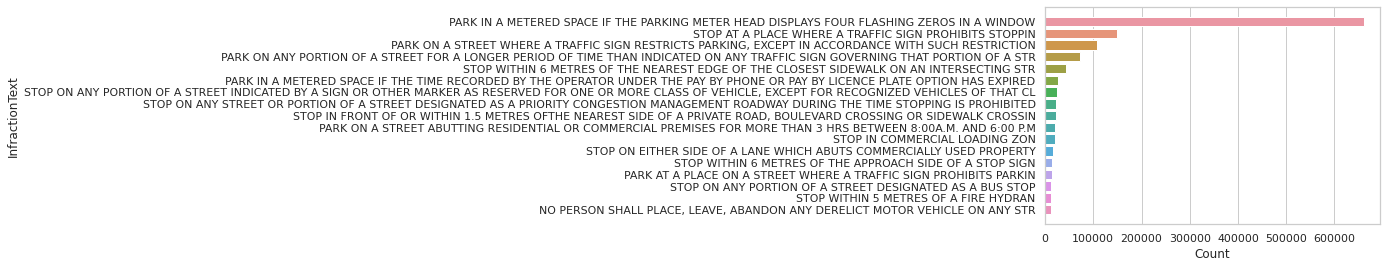

In [6]:
categorical_feature_study(df, "InfractionText", horizontal=True, treshould=10000).head()

,Infraction_Type,Count
0,METERED,690170
1,STOP OR PARK,604483
2,OTHER,12284
3,LARGE VEHICLE PARKED INCORRECTLY,9821
4,"CAUSE, ALLOW OR PERMIT",1068
5,WATER LAWN/FIELD... OUTSIDE PERMITTED HOUR/DAY,796
6,WASTING WATER,110
7,WATER - OTHER,3


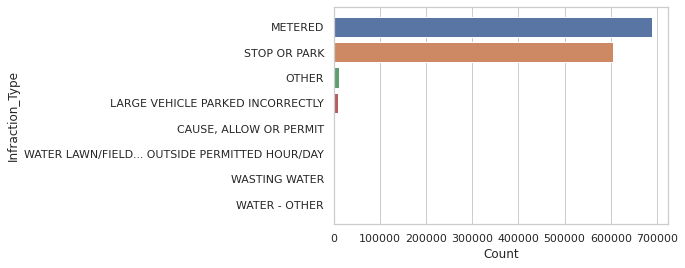

In [7]:
categorical_feature_study(df, "Infraction_Type", horizontal=True).head(10)

,Street,Count
0,W BROADWAY,43603
1,W 4TH AVE,31322
2,HOMER ST,29818
3,RICHARDS ST,28612
4,ROBSON ST,28438


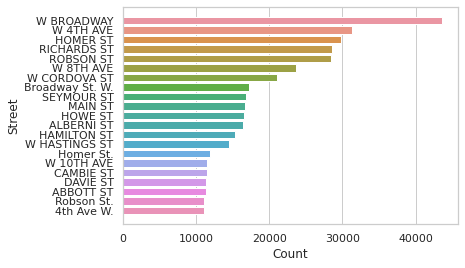

In [8]:
categorical_feature_study(df, "Street", horizontal=True, treshould=10000).head()

,Year,Count
0,2018,456287
1,2019,434387
2,2017,428061


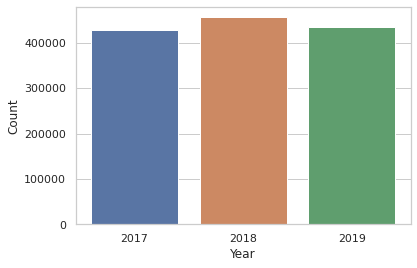

In [9]:
categorical_feature_study(df, "Year", horizontal=False)

As we can observe in the figure above, the number of infractions per year is similar in the different years.

,Bylaw,Count
0,2952,690170
1,2849,625978
2,9978,966
3,12086,909
4,9344,712


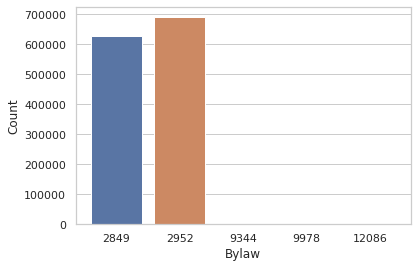

In [10]:
categorical_feature_study(df, "Bylaw", horizontal=False)

There are two major Bylaws: 2952 and 2849.

The 2952 Bylaw [webpage](https://vancouver.ca/streets-transportation/metered-parking.aspx) regulates the "Metered parking".

The 2849 Bylaw [webpage](https://vancouver.ca/your-government/street-traffic-bylaw.aspx) "Regulates traffic, the use of streets, and the size and weight of vehicles that are permitted to travel on City of Vancouver streets."

,HBLOCK,Count
0,1100 ALBERNI ST,9860
1,800 RICHARDS ST,8805
2,800 HOMER ST,7381
3,1000 ROBSON ST,7154
4,1000 HOMER ST,7076


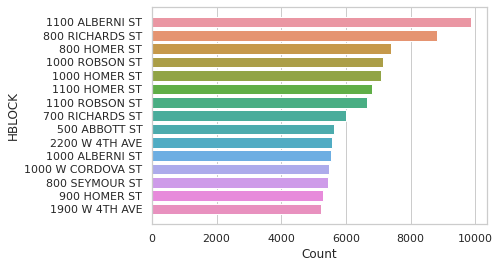

In [11]:
categorical_feature_study(df, "HBLOCK", horizontal=True, treshould=5000).head()

## Encode categorical features

In [12]:
enc = OrdinalEncoder()
df["InfractionText"] = enc.fit_transform(df[["InfractionText"]]).astype(int)

df_infraction = categorical_feature_study(df, "InfractionText", horizontal=True, treshould=10000, plot=False)
df_infraction.head()

,InfractionText,Count
0,19,661299
1,30,149981
2,23,107990
3,24,71519
4,71,43784


In [13]:
enc = OrdinalEncoder()
df["Street"] = enc.fit_transform(df[["Street"]]).astype(int)

df_streets = categorical_feature_study(df, "Street", horizontal=True, treshould=10000, plot=False)
df_streets.head()

,Street,Count
0,1688,43603
1,1654,31322
2,806,29818
3,1343,28612
4,1348,28438


## Number of infractions per day

<AxesSubplot:xlabel='EntryDate', ylabel='Count'>

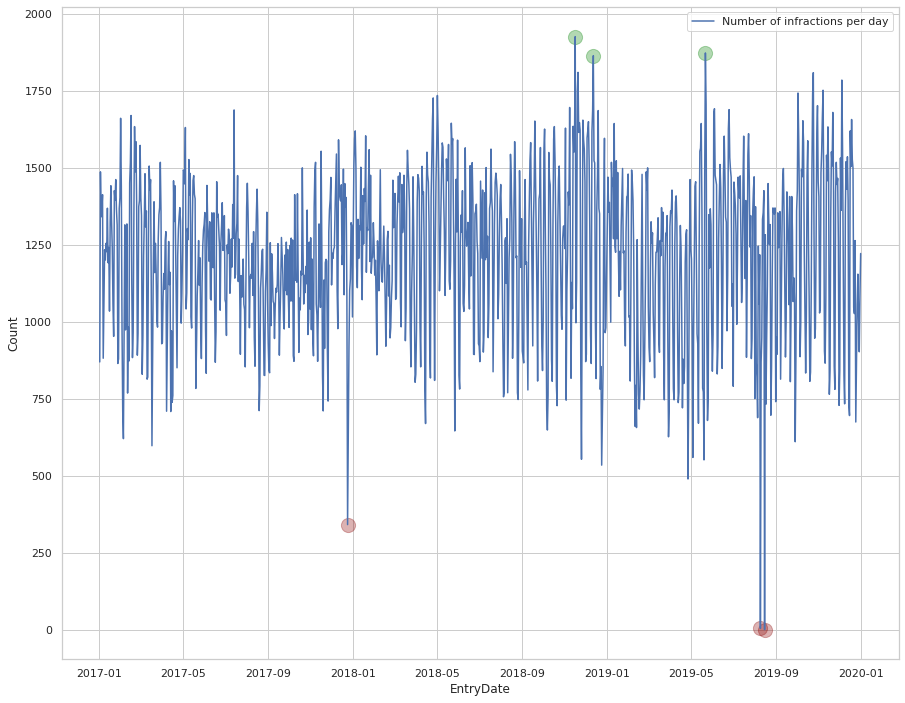

In [14]:
nInfractionsPerDay = df.groupby(['EntryDate']) \
                        .count() \
                        .rename(columns={'Block':'Count'})[['Count']] \
                        .reset_index()

# Obtain the top 3 local maximums and the top 3 local minimums 
minimos = nInfractionsPerDay[nInfractionsPerDay.Count<400]
maximos = nInfractionsPerDay[nInfractionsPerDay.Count>1850]

fig, ax = pyplot.subplots(figsize=(15,12))
sns.lineplot(data=nInfractionsPerDay, x="EntryDate", y="Count", ax=ax, label="Number of infractions per day")
sns.regplot(data=minimos, x="EntryDate", y="Count", fit_reg=False, 
            scatter_kws={"color":"darkred","alpha":0.3,"s":200})
sns.regplot(data=maximos, x="EntryDate", y="Count", fit_reg=False, 
            scatter_kws={"color":"green","alpha":0.3,"s":200})

Existem 3 mínimos locais que chamam à atenção (datas...) e 3 máximos. Realçar os 2 nínimos cujo valor é de 5 e 1 e dizer que são extremamente baixos dados os outros valores.

## Number of infractions per day per type of infraction

<AxesSubplot:xlabel='EntryDate', ylabel='Count'>

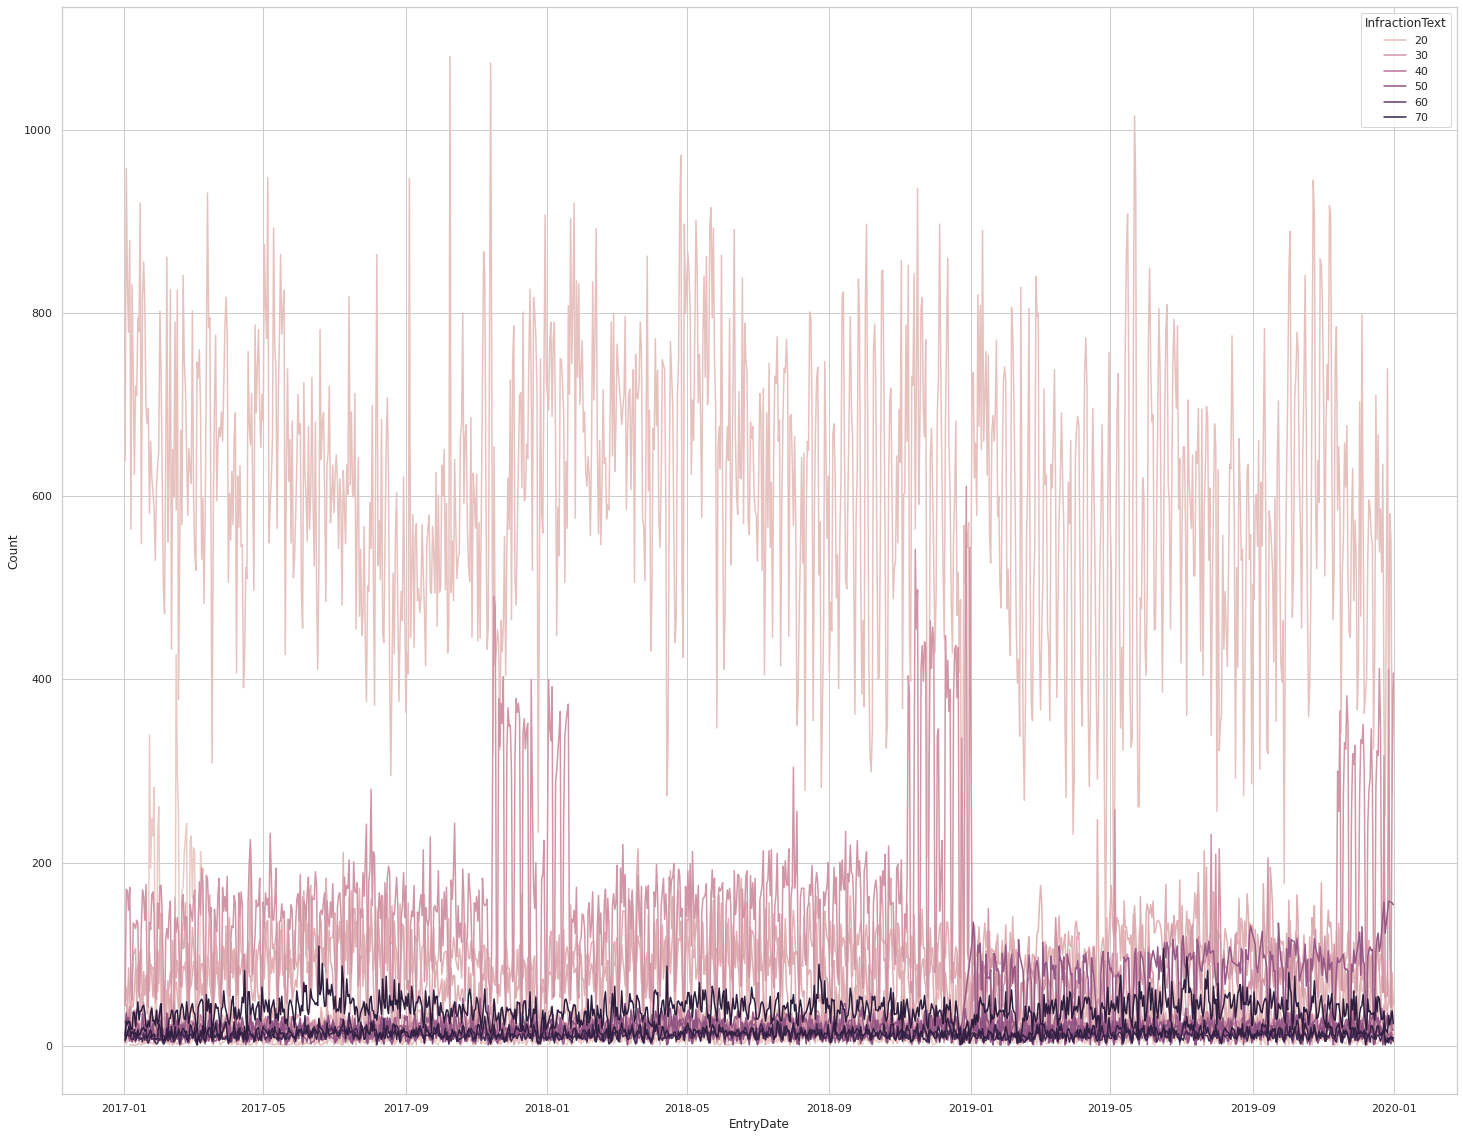

In [17]:
popular_infractions = df_infraction.InfractionText.tolist()

# number of Infractions per Day and per Type
nIDT = df.copy()
nIDT = nIDT[nIDT["InfractionText"].isin(popular_infractions)]
nIDT = nIDT.groupby(['EntryDate', 'InfractionText']) \
                                .count() \
                                .rename(columns={'Block':'Count'})[['Count']]\
                                .reset_index()

# plot most popular infractions
fig, ax = pyplot.subplots(figsize=(25,20))
sns.lineplot(data=nIDT, x="EntryDate", y="Count", hue="InfractionText", ax=ax)

## Number of Infractions per Day per Type per Street

In [18]:
popular_streets = df_streets.Street.tolist()

# number of Infractions per Day per Type per Street
nIDTS = df.copy()
nIDTS = nIDTS[(nIDTS["Street"].isin(popular_streets)) & (nIDTS["InfractionText"].isin(popular_infractions))]
nIDTS = nIDTS.groupby(['EntryDate', 'InfractionText', 'Street']) \
                                .count() \
                                .rename(columns={'Block':'Count'})[['Count']]\
                                .reset_index()

nIDTS['Street_str'] = nIDTS['Street'].astype(str)
nIDTS['InfractionText_str'] = nIDTS['InfractionText'].astype(str)
nIDTS['Street_&_Infraction'] = nIDTS['Street_str'] + ["___"]*len(nIDTS) + nIDTS['InfractionText_str']
nIDTS

,EntryDate,InfractionText,Street,Count,Street_str,InfractionText_str,Street_&_Infraction
0,2017-01-02,19,87,44,87,19,87___19
1,2017-01-02,19,326,31,326,19,326___19
2,2017-01-02,19,847,21,847,19,847___19
3,2017-01-02,19,1379,29,1379,19,1379___19
4,2017-01-02,23,1379,4,1379,23,1379___23
...,...,...,...,...,...,...,...
47933,2019-12-31,50,1014,1,1014,50,1014___50
47934,2019-12-31,50,1343,1,1343,50,1343___50
47935,2019-12-31,50,1689,1,1689,50,1689___50
47936,2019-12-31,66,339,2,339,66,339___66


<AxesSubplot:xlabel='EntryDate', ylabel='Count'>

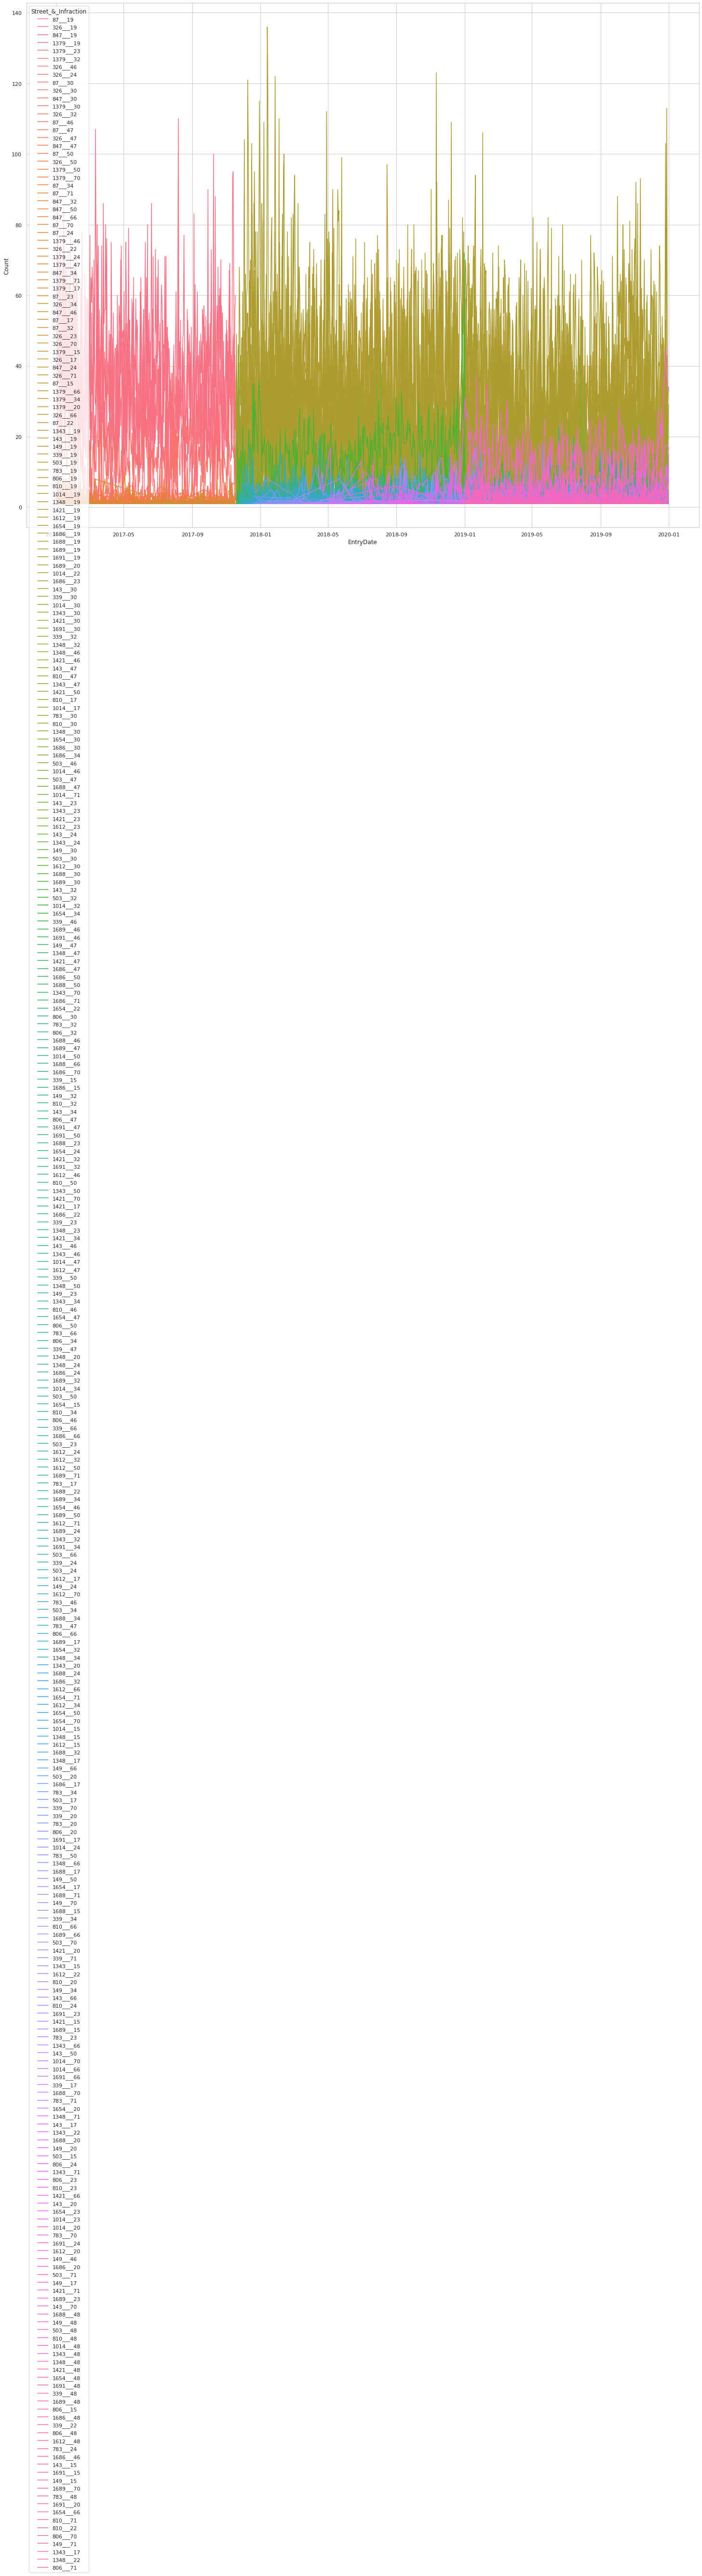

In [19]:
fig, ax = pyplot.subplots(figsize=(25,20))
sns.lineplot(data=nIDTS, x="EntryDate", y="Count", hue="Street_&_Infraction", ax=ax)

In [20]:
nIDTS

,EntryDate,InfractionText,Street,Count,Street_str,InfractionText_str,Street_&_Infraction
0,2017-01-02,19,87,44,87,19,87___19
1,2017-01-02,19,326,31,326,19,326___19
2,2017-01-02,19,847,21,847,19,847___19
3,2017-01-02,19,1379,29,1379,19,1379___19
4,2017-01-02,23,1379,4,1379,23,1379___23
...,...,...,...,...,...,...,...
47933,2019-12-31,50,1014,1,1014,50,1014___50
47934,2019-12-31,50,1343,1,1343,50,1343___50
47935,2019-12-31,50,1689,1,1689,50,1689___50
47936,2019-12-31,66,339,2,339,66,339___66


<AxesSubplot:xlabel='EntryDate', ylabel='Count'>

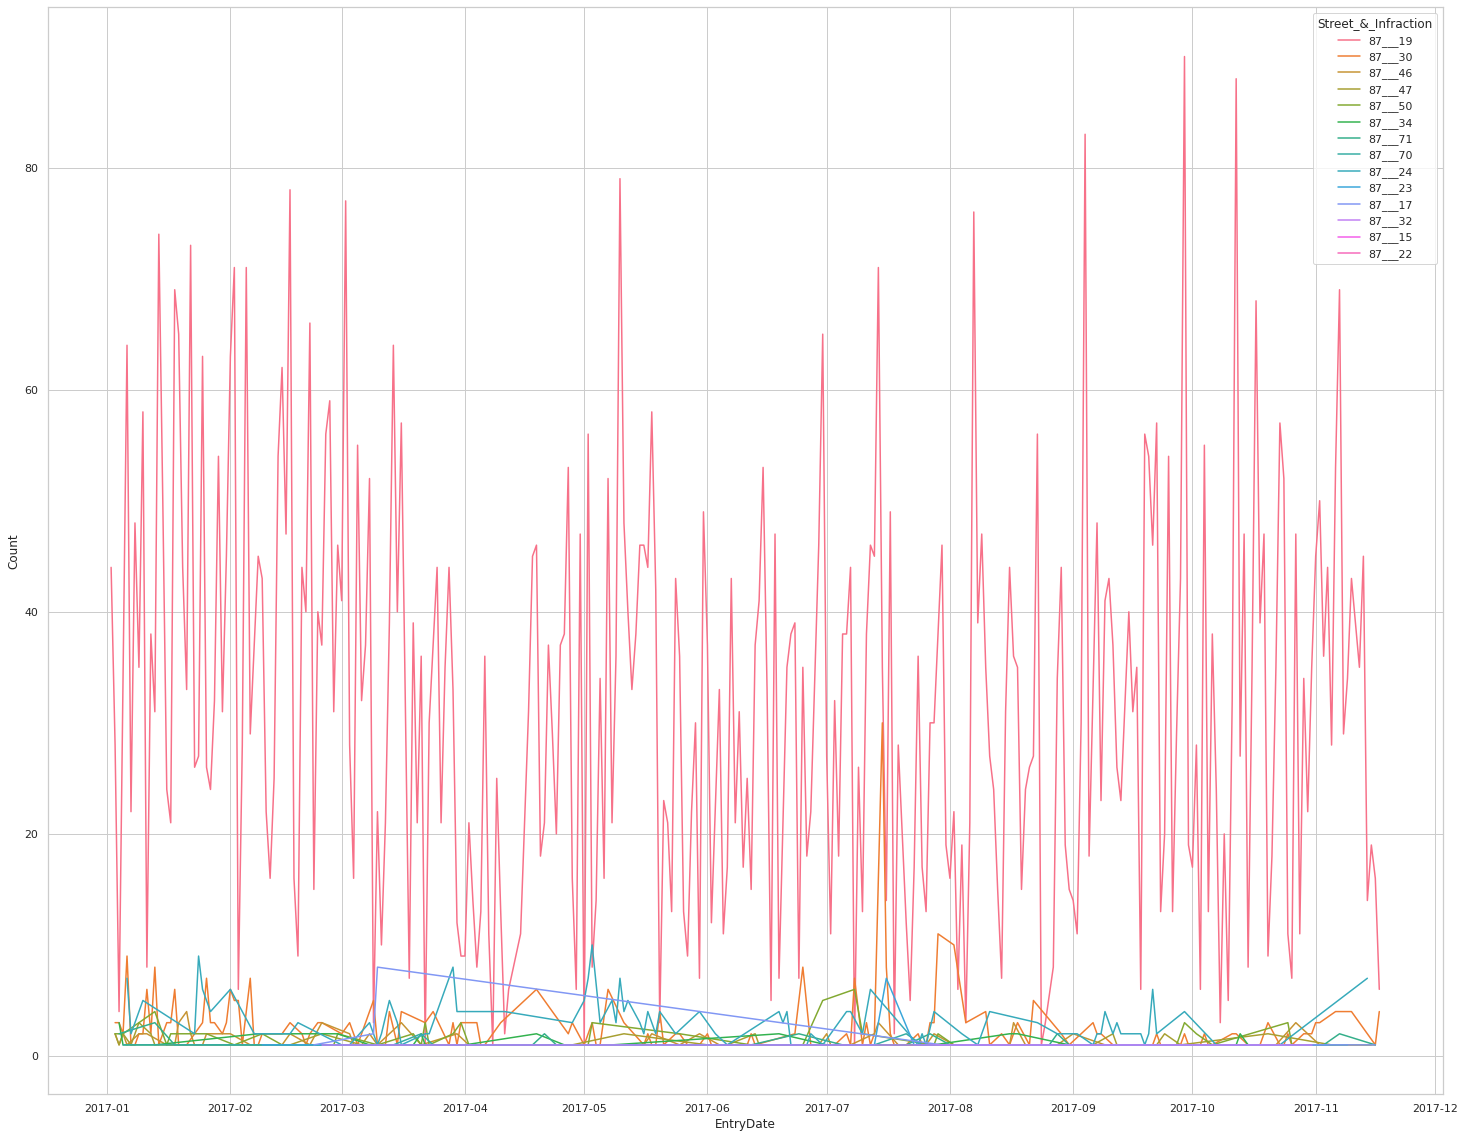

In [21]:
nIDTS_filter = nIDTS[nIDTS['Street']==87]
fig, ax = pyplot.subplots(figsize=(25,20))
sns.lineplot(data=nIDTS_filter, x="EntryDate", y="Count", hue="Street_&_Infraction", ax=ax)

In [22]:
nIDTS_filter[['Count']].head()

,Count
0,44
7,28
13,3
19,2
20,2


# External data
## Holiday dataset

In [23]:
holiday_df = pd.read_csv('holidays.csv', sep=',',parse_dates=['date'])
holiday_df.head()

,date,holiday
0,2017-01-01,New Year's Day
1,2017-02-20,Family Day
2,2017-04-14,Good Friday
3,2017-05-22,Victoria Day
4,2017-07-03,Canada Day


,Count
count,1089.000000
mean,1210.959596
std,262.500196
min,1.000000
10%,846.200000
20%,970.600000
30%,1075.400000
40%,1160.200000
50%,1241.000000
60%,1309.800000


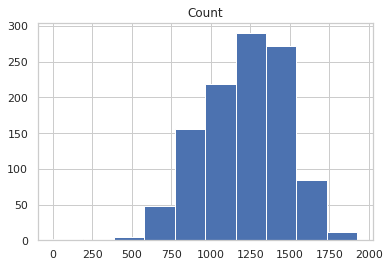

In [24]:
nInfractionsPerDay = df.groupby(['EntryDate']) \
    .count() \
    .rename(columns={'Block': 'Count'})[['Count']] \
    .reset_index()
nInfractionsPerDay["dayOfWeek"] = nInfractionsPerDay.apply(
    lambda row: row.EntryDate.weekday(), axis=1)
nInfractionsPerDay = pd.merge(nInfractionsPerDay, holiday_df, how='left', left_on='EntryDate',
                              right_on='date').drop(columns=['date']).fillna(0, downcast='infer')
nInfractionsPerDay["holiday"] = nInfractionsPerDay.apply(
    lambda row: 0 if row.holiday == 0 else 1, axis=1)

h = nInfractionsPerDay[["Count"]].hist()

nInfractionsPerDay[["Count"]].describe([.1, .2, .3, .4, .5, .6, .7, .8, .9])

In [25]:
mapping_dic = {
    1: [0, 970.6],
    2: [970.6, 1160.2],
    3: [1160.2, 1309.8],
    4: [1309.8, 1448.4],
    5: [1448.4, -1]
}


def map_to_cat(num):
    for key, ranges in mapping_dic.items():
        if num >= ranges[0] and (ranges[1] == -1 or num < ranges[1]):
            return key

    print("Negative values not allowed")
    return -1


dfCat = nInfractionsPerDay.copy()
dfCat["countCat"] = dfCat.apply(lambda row: map_to_cat(row.Count), axis=1)

del dfCat["Count"]
dfCat

,EntryDate,dayOfWeek,holiday,countCat
0,2017-01-02,0,0,1
1,2017-01-03,1,0,5
2,2017-01-04,2,0,4
3,2017-01-05,3,0,4
4,2017-01-06,4,0,4
...,...,...,...,...
1084,2019-12-27,4,0,2
1085,2019-12-28,5,0,2
1086,2019-12-29,6,0,1
1087,2019-12-30,0,0,2


In [26]:
df_parking_holidays = pd.merge(df,holiday_df, how='left', left_on='EntryDate', right_on='date').drop(columns= ['date'])
#df_parking_holidays[df_parking_holidays['EntryDate'] == '2017-02-20'] #look at infraction in one holliday
df_parking_holidays.head(10)

,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK,Infraction_Stage,Infraction_Type,holiday
0,1400,934,2017-08-23,2849,17.1,IS,30,2017,1400 KINGSWAY,0,STOP OR PARK,NaN
1,2100,6,2017-08-26,2849,19.1(H),IS,50,2017,2100 13TH AVE E,0,STOP OR PARK,NaN
2,2800,1570,2017-08-26,2849,17.6(B),VA,23,2017,2800 TRINITY ST,0,STOP OR PARK,NaN
3,200,15,2017-08-27,2849,17.5(B),IS,71,2017,200 17TH AVE W,0,STOP OR PARK,NaN
4,1900,87,2017-08-19,2952,5(4)(a)(ii),IS,19,2017,1900 4TH AVE W,0,METERED,NaN
5,1900,87,2017-08-19,2952,5(4)(a)(ii),WR,19,2017,1900 4TH AVE W,0,METERED,NaN
6,700,1374,2017-08-19,2952,5(4)(a)(ii),IS,19,2017,700 RICHARDS ST,0,METERED,NaN
7,1000,1090,2017-08-20,2952,5(4)(a)(ii),IS,19,2017,1000 MAINLAND ST,0,METERED,NaN
8,500,141,2017-08-20,2952,5(4)(a)(ii),IS,19,2017,500 8TH AVE W,0,METERED,NaN
9,500,139,2017-08-20,2952,5(4)(a)(ii),IS,19,2017,500 7TH AVE W,0,METERED,NaN


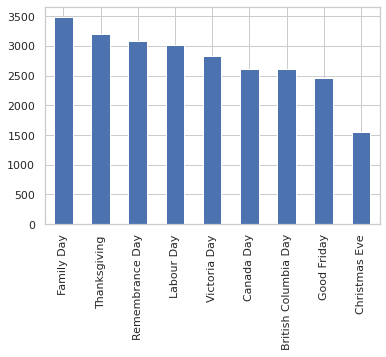

In [27]:
df_holiday_infraction_count = df_parking_holidays.holiday.value_counts().plot(kind='bar')

In [28]:
holiday_df.holiday.unique()

array(["New Year's Day", 'Family Day', 'Good Friday', 'Victoria Day',
       'Canada Day', 'British Columbia Day', 'Labour Day', 'Thanksgiving',
       'Remembrance Day', 'Christmas Eve', 'Christmas Day'], dtype=object)

Family day, Thanksgiving, Remembrance day and Victoria day are the holidays with the most infractions. Christmas eve is the holiday where fewer infractions happen. Note the absence of 2 holidays: christmas day and new year's day. Because stores, attractions and many services are closed in these holidays, there is less traffic and perhaps less fiscalization.

<AxesSubplot:xlabel='holiday', ylabel='Count'>

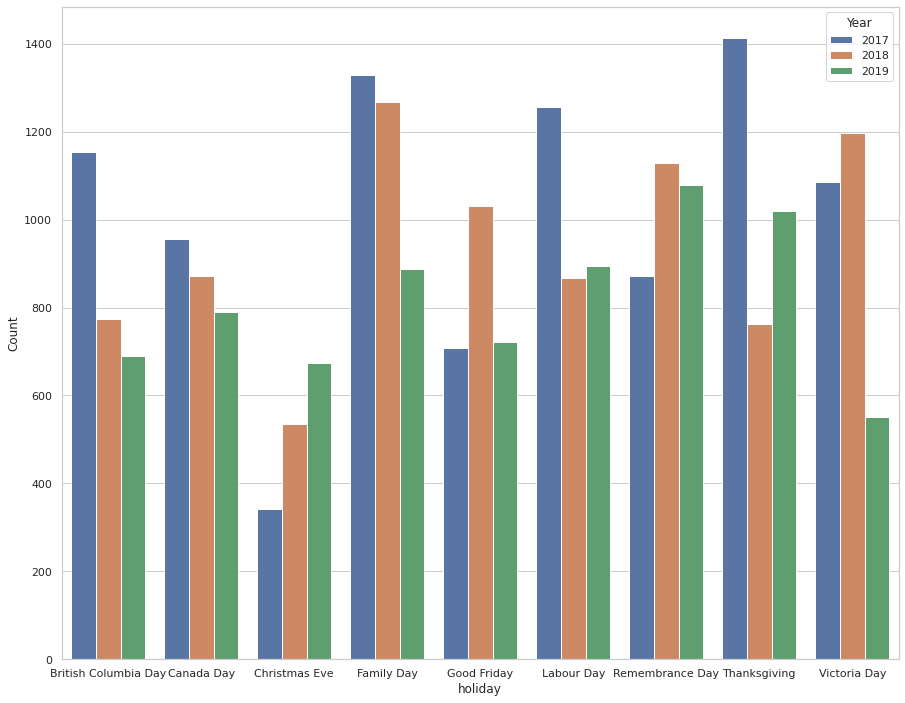

In [29]:
# Infractions per holiday per year
infrac_per_holyday_year = df_parking_holidays.groupby(['Year', 'holiday']) \
                                .count() \
                                .rename(columns={'Block':'Count'})[['Count']]\
                                .reset_index()

fig, ax = pyplot.subplots(figsize=(15,12))
sns.barplot(x="holiday", y="Count", hue="Year", data=infrac_per_holyday_year, ax=ax)

ADICIONAR TEXTO

In [30]:
# Infractions per holiday per year per type
infrac_per_holyday_year_type = df_parking_holidays.groupby(['Year', 'holiday', 'Infraction_Type']) \
                                .count() \
                                .rename(columns={'Block':'Count'})[['Count']]\
                                .reset_index()
infrac_per_holyday_year_type

,Year,holiday,Infraction_Type,Count
0,2017,British Columbia Day,"CAUSE, ALLOW OR PERMIT",1
1,2017,British Columbia Day,LARGE VEHICLE PARKED INCORRECTLY,4
2,2017,British Columbia Day,METERED,876
3,2017,British Columbia Day,STOP OR PARK,273
4,2017,Canada Day,"CAUSE, ALLOW OR PERMIT",1
...,...,...,...,...
99,2019,Thanksgiving,STOP OR PARK,282
100,2019,Victoria Day,"CAUSE, ALLOW OR PERMIT",1
101,2019,Victoria Day,LARGE VEHICLE PARKED INCORRECTLY,4
102,2019,Victoria Day,METERED,365


Text(0.5, 1.0, '2019')

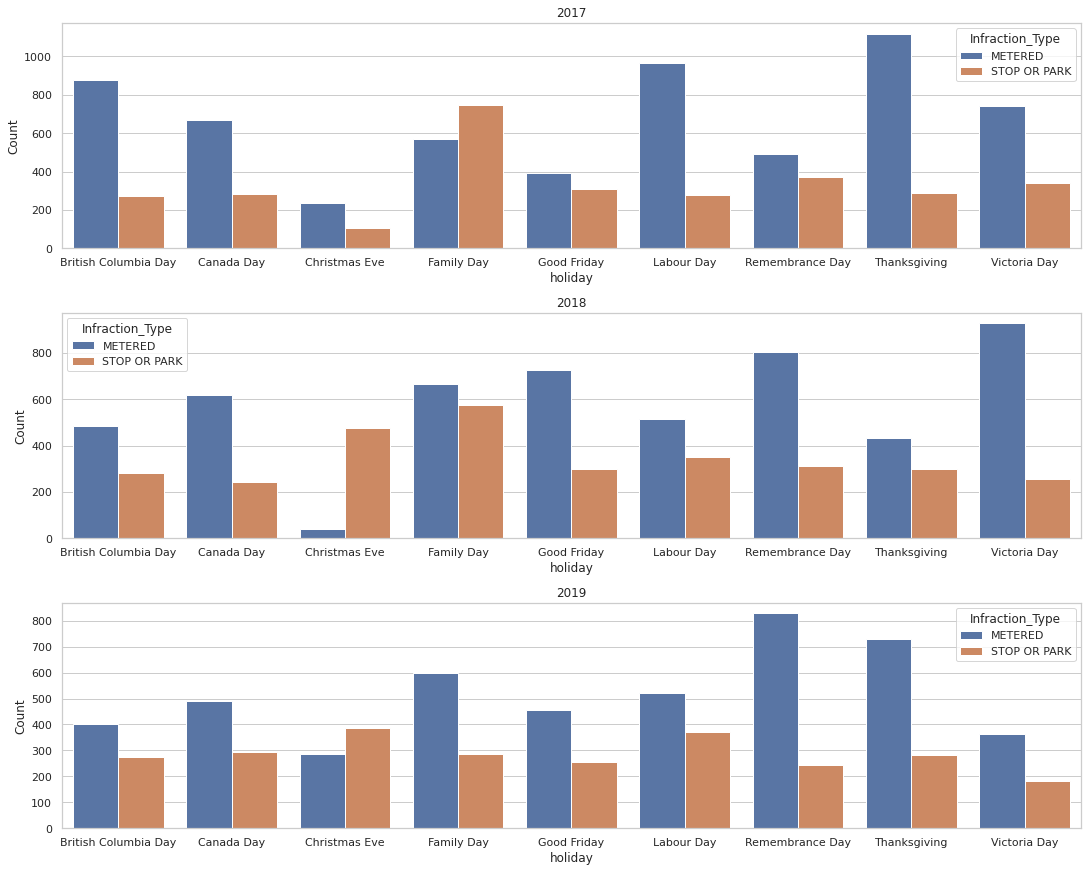

In [40]:
order_infr=['METERED', 'STOP OR PARK'] # The most popular infrations
# 'OTHER', 'LARGE VEHICLE PARKED INCORRECTLY', 'CAUSE, ALLOW OR PERMIT', 
# 'WATER LAWN/FIELD... OUTSIDE PERMITTED HOUR/DAY',
#'WASTING WATER','WATER - OTHER']

fig, ax = pyplot.subplots(nrows=3, ncols=1, figsize=(15,12), constrained_layout=True)
sns.barplot(x="holiday", y="Count", hue="Infraction_Type", hue_order=order_infr,
            data=infrac_per_holyday_year_type[infrac_per_holyday_year_type.Year==2017], ax=ax[0])
sns.barplot(x="holiday", y="Count", hue="Infraction_Type", hue_order=order_infr,
            data=infrac_per_holyday_year_type[infrac_per_holyday_year_type.Year==2018], ax=ax[1])
sns.barplot(x="holiday", y="Count", hue="Infraction_Type", hue_order=order_infr,
            data=infrac_per_holyday_year_type[infrac_per_holyday_year_type.Year==2019], ax=ax[2])
ax[0].set_title('2017')
ax[1].set_title('2018')
ax[2].set_title('2019')

ADICIONAR TEXTO

### Create new dataset for timeseries analysis on oracle

In [32]:
df_parking_holidays_count_street_and_day = df_parking_holidays\
    .groupby(['InfractionText', 'EntryDate', 'holiday'], dropna=False, as_index=False)['Street'].count().\
    rename(columns={'Street':'infraction_count'})
pd.set_option('max_colwidth', 400)
df_parking_holidays_count_street_and_day.head(20)

,InfractionText,EntryDate,holiday,infraction_count
0,0,2017-01-04,NaN,1
1,0,2017-01-07,NaN,1
2,0,2017-01-19,NaN,2
3,0,2017-01-30,NaN,1
4,0,2017-02-03,NaN,3
5,0,2017-02-07,NaN,1
6,0,2017-02-10,NaN,1
7,0,2017-02-18,NaN,1
8,0,2017-02-27,NaN,1
9,0,2017-03-01,NaN,1


In [33]:
df_parking_holidays_count_street_and_day.holiday.unique()

array([nan, 'Good Friday', 'Family Day', 'Remembrance Day',
       'Victoria Day', 'British Columbia Day', 'Canada Day',
       'Christmas Eve', 'Labour Day', 'Thanksgiving'], dtype=object)

In [34]:
# df_parking_holidays_count_street_and_day.to_csv(r'/home/bsilva/Desktop/irregular_parking_count_infractions_by_day.csv', index = False)

In [35]:
df_parking_holidays_count_by_street_and_day = df_parking_holidays\
    .groupby(['Street','EntryDate', 'holiday'], dropna=False, as_index=False)['InfractionText'].count().\
    rename(columns={'InfractionText':'infraction_count'})
pd.set_option('max_colwidth', 400)
df_parking_holidays_count_by_street_and_day.head()

,Street,EntryDate,holiday,infraction_count
0,0,2017-01-03,NaN,3
1,0,2017-01-04,NaN,2
2,0,2017-01-05,NaN,2
3,0,2017-01-06,NaN,9
4,0,2017-01-07,NaN,3


In [36]:
# df_parking_holidays_count_by_street_and_day.to_csv(r'/home/bsilva/Desktop/irregular_parking_count_street_by_day.csv', index = False)

In [37]:
df_parking_holidays_only = df_parking_holidays[df_parking_holidays['holiday'].notnull()]
df_parking_holidays_only = df_parking_holidays_only.groupby('holiday')
df_parking_holidays_only.head(5)

,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK,Infraction_Stage,Infraction_Type,holiday
511,300,632,2018-12-24,2849,17.6(B),IS,23,2018,300 E PENDER ST,0,STOP OR PARK,Christmas Eve
512,600,806,2018-12-24,2849,17.1,IS,30,2018,600 HOMER ST,0,STOP OR PARK,Christmas Eve
539,1500,274,2018-12-24,2849,18.1(B),VA,57,2018,1500 BURNABY ST,0,STOP OR PARK,Christmas Eve
623,1700,503,2018-12-24,2849,17.1,IS,30,2018,1700 DAVIE ST,0,STOP OR PARK,Christmas Eve
773,100,503,2018-12-24,2849,17.2(J),IS,47,2018,100 DAVIE ST,0,STOP OR PARK,Christmas Eve
6526,800,1343,2019-05-20,9978,10,VA,1,2019,800 RICHARDS ST,0,"CAUSE, ALLOW OR PERMIT",Victoria Day
6527,1000,1027,2019-05-20,2849,21.1,IS,36,2019,1000 MARINASIDE CR,0,STOP OR PARK,Victoria Day
8051,800,1205,2017-09-04,2952,5(4)(a)(ii),VA,19,2017,800 NELSON ST,0,METERED,Labour Day
8052,1000,482,2017-09-04,2952,5(4)(a)(ii),IS,19,2017,1000 CORDOVA ST W,0,METERED,Labour Day
8053,600,1482,2017-09-04,2952,5(4)(a)(ii),IS,19,2017,600 SEYMOUR ST,0,METERED,Labour Day


# Using Oracle Cloud Infratructure to perform forecasting

## ARIMA, SARIMA, ETS

# ??

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀